#**SETUP**

In [2]:
! pip install -q transformers
! pip install -q simpletransformers
! pip install -q transformers torch
! pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/AI/Crawl_Data/
!chmod +x setup.sh > /dev/null 2>&1
!./setup.sh > /dev/null 2>&1

/content/drive/MyDrive/AI/Crawl_Data


In [5]:
from tqdm.notebook import tqdm
import time
import os
import csv
import pandas as pd
import numpy as np

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

service = Service(executable_path=r'/usr/bin/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.headless = True

#**DATA CRAWLING**

In [ ]:
def crawl_tv_data(main_url, num_products, save_path):

    driver = webdriver.Chrome(service=service, options=chrome_options)
    driver.implicitly_wait(5)
    wait = WebDriverWait(driver, 10)
    datasets = []
    driver.get(main_url)

    for idx in tqdm(range(1, num_products + 1), desc="Processing products"):
        # Exclusively right for DienMayXanh
        name_xpath = f'//*[@id="categoryPage"]/div[3]/ul/li[{idx}]//a[1]/h3'
        price_xpath = f'//*[@id="categoryPage"]/div[3]/ul/li[{idx}]/a[1]/strong'
        number_rating_xpath = f'//*[@id="categoryPage"]/div[3]/ul/li[{idx}]/div[1]/p[2]'
        detail_url_xpath = f'//*[@id="categoryPage"]/div[3]/ul/li[{idx}]/a[1]'

        try:
            retries = 3
            while retries > 0:
                try:
                    name_tag = wait.until(EC.presence_of_element_located((By.XPATH, name_xpath))).text
                    price_tag = wait.until(EC.presence_of_element_located((By.XPATH, price_xpath))).text
                    number_rating_tag = wait.until(EC.presence_of_element_located((By.XPATH, number_rating_xpath))).text
                    get_detail_url = wait.until(EC.presence_of_element_located((By.XPATH, detail_url_xpath))).get_attribute('href')
                    break
                except StaleElementReferenceException:
                    retries -= 1
                    if retries == 0:
                        raise

            comments = []
            rating_star = "No rating available"
            comment_detail_url = get_detail_url.replace("?utm_flashsale=1", "") + "/danh-gia?"
            try:
                driver.get(comment_detail_url)
                time.sleep(5)
                try:
                    rating_star_path = f'/html/body/div[6]/div/div[2]/div/div/div[1]/div[2]/div[1]/p'
                    rating_star_elements = wait.until(EC.presence_of_all_elements_located((By.XPATH, rating_star_path)))
                    if rating_star_elements:
                        rating_star = rating_star_elements[0].text
                    comments_element = driver.find_elements(By.CSS_SELECTOR, ".cmt-txt")
                    for cmt in comments_element:
                        comments.append(cmt.text + "/n")
                except:
                    pass
            except Exception as e:
                tqdm.write(f"Error occurred while processing comments for product {idx}: {e}")

            list_info = {
                'Name': name_tag,
                'Cost': price_tag,
                'Score rating': rating_star,
                'Number rating': number_rating_tag,
                'Comment user': comments
            }
            datasets.append(list_info)
            driver.get(main_url)

        except TimeoutException:
            tqdm.write(f"TimeoutException! Skip Product {idx}.")

    folder_path = os.path.dirname(save_path)
    os.makedirs(folder_path, exist_ok=True)

    field_names = ['Name', 'Cost', 'Score rating', 'Number rating', 'Comment user']

    with open(save_path, mode='w', newline='', encoding='utf-8-sig') as file:
        writer = csv.DictWriter(file, fieldnames=field_names)
        writer.writeheader()
        for data in datasets:
            writer.writerow(data)

    driver.quit()

In [ ]:
samsung_url = 'https://www.dienmayxanh.com/tivi-samsung#c=1942&m=2002&o=13&pi=5'
samsung_num_products = 103
samsung_path = '/content/drive/My Drive/AI/Crawl_Data/data/samsungtvdata.csv'

crawl_tv_data(samsung_url, samsung_num_products, samsung_path)

Processing products:   0%|          | 0/103 [00:00<?, ?it/s]

TimeoutException! Skip Product 4.
TimeoutException! Skip Product 19.
TimeoutException! Skip Product 27.
TimeoutException! Skip Product 32.
TimeoutException! Skip Product 35.
TimeoutException! Skip Product 41.
TimeoutException! Skip Product 43.
TimeoutException! Skip Product 45.
TimeoutException! Skip Product 48.
TimeoutException! Skip Product 53.
TimeoutException! Skip Product 54.
TimeoutException! Skip Product 55.
TimeoutException! Skip Product 56.
TimeoutException! Skip Product 57.
TimeoutException! Skip Product 58.
TimeoutException! Skip Product 59.
TimeoutException! Skip Product 60.
TimeoutException! Skip Product 61.
TimeoutException! Skip Product 64.
TimeoutException! Skip Product 65.
TimeoutException! Skip Product 66.
TimeoutException! Skip Product 67.
TimeoutException! Skip Product 68.
TimeoutException! Skip Product 69.
TimeoutException! Skip Product 70.
TimeoutException! Skip Product 71.
TimeoutException! Skip Product 72.
TimeoutException! Skip Product 73.
TimeoutException! Ski

In [ ]:
all_url = 'https://www.dienmayxanh.com/tivi-toshiba#c=1942&m=2001,2005,2003,722,37306,2004,35330,24750,38159&o=13&pi=8'
all_num_products = 180
all_path = '/content/drive/My Drive/AI/Crawl_Data/data/tvdata.csv'

crawl_tv_data(all_url, all_num_products, all_path)

Processing products:   0%|          | 0/180 [00:00<?, ?it/s]

TimeoutException! Skip Product 24.
TimeoutException! Skip Product 27.
TimeoutException! Skip Product 39.
TimeoutException! Skip Product 48.
TimeoutException! Skip Product 52.
TimeoutException! Skip Product 56.
TimeoutException! Skip Product 57.
TimeoutException! Skip Product 58.
TimeoutException! Skip Product 59.
TimeoutException! Skip Product 63.
TimeoutException! Skip Product 65.
TimeoutException! Skip Product 66.
TimeoutException! Skip Product 67.
TimeoutException! Skip Product 68.
TimeoutException! Skip Product 70.
TimeoutException! Skip Product 74.
TimeoutException! Skip Product 75.
TimeoutException! Skip Product 76.
TimeoutException! Skip Product 78.
TimeoutException! Skip Product 79.
TimeoutException! Skip Product 80.
TimeoutException! Skip Product 81.
TimeoutException! Skip Product 82.
TimeoutException! Skip Product 84.
TimeoutException! Skip Product 85.
TimeoutException! Skip Product 86.
TimeoutException! Skip Product 89.
TimeoutException! Skip Product 91.
TimeoutException! Sk

In [ ]:
import pandas as pd

csv_file_path = '/content/drive/My Drive/AI/Crawl_Data/data/samsungtvdata.csv'

data = pd.read_csv(csv_file_path, encoding='utf-8-sig')

print(data)

                                           Name         Cost  Score rating  \
0                Samsung Smart TV QLED QA55Q60C  13.490.000₫           4.3   
1                   Samsung Smart TV UA55AU7002   8.490.000₫           4.5   
2                   Samsung Smart TV UA55BU8000  12.900.000₫           4.3   
3                   Samsung Smart TV UA55CU8000  10.990.000₫           4.8   
4                Samsung Smart TV QLED QA65Q60C  16.390.000₫           3.9   
5                   Samsung Smart TV UA43AU7002   6.490.000₫           4.3   
6                   Samsung Smart TV UA65CU8000  12.790.000₫           4.5   
7                   Samsung Smart TV UA43CU8000   9.800.000₫           4.5   
8                    Samsung Smart TV UA32T4202   4.690.000₫           4.2   
9       Samsung Smart TV Crystal UHD UA43BU8000   9.300.000₫           4.5   
10                  Samsung Smart TV UA65AU7002  10.990.000₫           4.4   
11               Samsung Smart TV QLED QA50Q60C  12.290.000₫    

In [ ]:
import pandas as pd

csv_file_path = '/content/drive/My Drive/AI/Crawl_Data/data/tvdata.csv'

data = pd.read_csv(csv_file_path, encoding='utf-8-sig')

print(data)

                                Name         Cost         Score rating  \
0           Toshiba Smart TV 43V31MP   5.490.000₫                  4.1   
1         AQUA Android TV AQT55D67UG   6.990.000₫                  4.8   
2          TCL Google TV QLED 65Q646  11.990.000₫                  4.3   
3         Toshiba Google TV 65C350LP  13.990.000₫                  4.9   
4    Toshiba Smart TV OLED 65X9900LP  20.990.000₫                  4.4   
..                               ...          ...                  ...   
74              TCL Google TV 65C755  22.990.000₫  No rating available   
75           Hisense Google TV 65U6K  15.640.000₫  No rating available   
76  LG Smart TV 65QNED80TSA Mới 2024  28.890.000₫  No rating available   
77         TCL Google TV QLED 43Q636  11.490.000₫                  4.4   
78          iFFALCON Google TV 65U62  13.490.000₫                  3.9   

    Number rating                                       Comment user  
0             109  ['Mới giao hàng đc 1 

#**DATA PROCESSING**

In [ ]:
data_path_samsung = '/content/drive/My Drive/AI/Crawl_Data/data/samsungtvdata.csv'
data_path_tv = '/content/drive/My Drive/AI/Crawl_Data/data/tvdata.csv'

samsungdata = pd.read_csv(data_path_samsung)
tvdata = pd.read_csv(data_path_tv)

def prepare_comments(data):
    comments_list = []
    for comments in data['Comment user']:
        split_comments = comments.strip("[]").replace("'", "").split(', ')
        cleaned_comments = [comment.strip("/n").strip() for comment in split_comments if comment.strip("/n").strip()]
        comments_list.extend(cleaned_comments)
    return comments_list

comments_samsung = prepare_comments(samsungdata)
comments_tv = prepare_comments(tvdata)

comments_samsung_df = pd.DataFrame(comments_samsung, columns=['Comment'])
comments_tv_df = pd.DataFrame(comments_tv, columns=['Comment'])

aspects = ['giaodien', 'manhinh', 'amthanh', 'tinhnang', 'dichvu', 'giaca', 'tongthe']
for aspect in aspects:
    comments_tv_df[aspect] = None
    comments_samsung_df[aspect] = None

comments_tv_df = comments_tv_df[comments_tv_df['Comment'].str.strip().astype(bool)]
comments_samsung_df = comments_samsung_df[comments_samsung_df['Comment'].str.strip().astype(bool)]

comments_tv_df.to_csv('/content/drive/My Drive/AI/Crawl_Data/data/cmtdata.csv', index=False)

comments_samsung_df.to_csv('/content/drive/My Drive/AI/Crawl_Data/data/samsung_cmtdata.csv', index=False)

print(comments_tv_df.head())


                                             Comment giaodien manhinh amthanh  \
0                                       Hình ảnh nét     None    None    None   
1                                     chất lượng tốt     None    None    None   
2                                      Sử dụng tốt ạ     None    None    None   
3                                                 Ok     None    None    None   
4  Mới lắp đặt ngày 07.03.2024. Mẫu mã đẹp sang t...     None    None    None   

  tinhnang dichvu giaca  
0     None   None  None  
1     None   None  None  
2     None   None  None  
3     None   None  None  
4     None   None  None  


In [ ]:
import pandas as pd

# Load the original data
data_path = '/content/drive/MyDrive/AI/Crawl_Data/data/cmtdata.csv'
comments_df = pd.read_csv(data_path)

aspects = ['giaodien', 'manhinh', 'amthanh', 'tinhnang', 'dichvu', 'giaca', 'tongthe']

comments_df[aspects] = comments_df[aspects].fillna(0).astype(int)

filtered_comments_df = comments_df.dropna(subset=aspects, how='all')

filtered_comments_df.to_csv('/content/drive/MyDrive/AI/Crawl_Data/data/filtered_cmtdata.csv', index=False)

print(filtered_comments_df.head())


                                             Comment  giaodien  manhinh  \
0                                       Hình ảnh nét         2        1   
1                                     chất lượng tốt         2        2   
2                                      Sử dụng tốt ạ         2        2   
3                                                 Ok         2        2   
4  Mới lắp đặt ngày 07.03.2024. Mẫu mã đẹp sang t...         1        1   

   amthanh  tinhnang  dichvu  giaca  tongthe  
0        2         2       2      2        2  
1        2         2       2      2        1  
2        2         2       2      2        1  
3        2         2       2      2        1  
4        2         2       1      2        2  


# **DATA AUGMENTATION**

In [ ]:
# AUGEMENTATION 1: Thêm data chuẩn
import pandas as pd
bonus_data1 = {
    "Comment": [
        "Thiết kế tivi rất mỏng và hiện đại, rất hài lòng",
        "Âm thanh không rõ, cần cải thiện",
        "Màn hình sáng và rõ ràng nhưng giá cả hơi cao",
        "Tivi này có nhiều tính năng thông minh, rất tiện lợi",
        "Dịch vụ khách hàng chưa tốt, chờ đợi lâu khi cần hỗ trợ",
        "Chất lượng hình ảnh tốt nhưng thiếu tính năng kết nối",
        "Giá cả phải chăng, nhưng dịch vụ bảo hành không đáp ứng kịp thời",
        "Màn hình bị lỗi sọc sau một tháng sử dụng",
        "Tivi rất đẹp, màn hình lớn, phù hợp với không gian nhà tôi",
        "Âm thanh tuyệt vời nhưng màn hình thi thoảng bị đơ"
    ],
    "giaodien": [1, 2, 2, 2, 2, 2, 2, 2, 1, 2],
    "manhinh":  [2, 2, 1, 2, 2, 1, 2, 0, 1, 0],
    "amthanh":  [2, 0, 2, 2, 2, 2, 2, 2, 2, 1],
    "tinhnang": [2, 2, 2, 1, 2, 0, 2, 2, 2, 2],
    "dichvu":   [2, 2, 2, 2, 0, 2, 0, 2, 2, 2],
    "giaca":    [2, 2, 0, 2, 2, 2, 1, 2, 2, 2],
    "tongthe":  [1, 0, 2, 2, 2, 2, 2, 2, 2, 2]
}

bonus_df1 = pd.DataFrame(bonus_data1)

In [ ]:
bonus_df1

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,"Thiết kế tivi rất mỏng và hiện đại, rất hài lòng",1,2,2,2,2,2,1
1,"Âm thanh không rõ, cần cải thiện",2,2,0,2,2,2,0
2,Màn hình sáng và rõ ràng nhưng giá cả hơi cao,2,1,2,2,2,0,2
3,"Tivi này có nhiều tính năng thông minh, rất ti...",2,2,2,1,2,2,2
4,"Dịch vụ khách hàng chưa tốt, chờ đợi lâu khi c...",2,2,2,2,0,2,2
5,Chất lượng hình ảnh tốt nhưng thiếu tính năng ...,2,1,2,0,2,2,2
6,"Giá cả phải chăng, nhưng dịch vụ bảo hành khôn...",2,2,2,2,0,1,2
7,Màn hình bị lỗi sọc sau một tháng sử dụng,2,0,2,2,2,2,2
8,"Tivi rất đẹp, màn hình lớn, phù hợp với không ...",1,1,2,2,2,2,2
9,Âm thanh tuyệt vời nhưng màn hình thi thoảng b...,2,0,1,2,2,2,2


In [ ]:
# AUGEMENTATION 2: Thêm data cho từng khía cạnh, rồi nối chéo với nhau

templates = {
    "giaodien": {
        0: ["giao diện khó sử dụng", "thiết kế không bắt mắt"],
        1: ["thiết kế tivi rất mỏng và hiện đại", "giao diện trực quan, dễ sử dụng"],
        2: []
    },
    "manhinh": {
        0: ["màn hình bị lỗi sọc", "màn hình thi thoảng bị đơ"],
        1: ["màn hình sáng và rõ ràng", "hình ảnh tuyệt vời", "hình ảnh sắc nét", "độ phân giải cao", "hình ảnh siêu thực"],
        2: []
    },
    "amthanh": {
        0: ["âm thanh bị rè", "không nghe được", "âm thanh tệ", "âm thanh chán"],
        1: ["âm thanh tốt", "to và rõ", "âm thanh tuyệt vời"],
        2: []
    },
    "tinhnang": {
        0: ["tv giật lag", "bị lỗi giọng nói", "bị lỗi điều khiển"],
        1: ["tv chạy mượt", "tốt vầ tiện ích", "dễ sử dụng"],
        2: []
    },
    "dichvu": {
        0: ["giao hàng trễ", "không hỗ trợ", "thái độ nhân viên không tốt", "nhân viên thái độ"],
        1: ["giao hàng đúng giờ", "nhân viên nhiệt tình", "tư vấn nhiệt tình"],
        2: []
    },
    "giaca": {
        0: ["đắt", "không xứng với giá tiền", "mắc"],
        1: ["rẻ","trong tầm giá", "xứng với giá tiền"],
        2: []
    },
    "tongthe": {
        0: ["chất lượng kém", "không hài lòng", "thất vọng", "sẽ không quay lại"],
        1: ["ok", "ổn", "yên tâm sử dụng"],
        2: []
    },
}


In [ ]:
import random

def create_dataframe(templates, num_comments=100):
    comments_data = []
    while len(comments_data) < num_comments:
        aspects = list(templates.keys())
        random.shuffle(aspects)

        comment_parts = []
        labels = {}
        for aspect in aspects:
            state = random.choice([0, 1, 2])
            labels[aspect] = state
            if templates[aspect][state]:
                comment_parts.append(random.choice(templates[aspect][state]))

        punctuation = random.choice([" ", ", ", ". "]) # Đảo việc chuyển dấu câu: " "; ", "; ". " phá bỏ cấu trúc câu thôgn thường.
        comment = punctuation.join(comment_parts)
        if comment:
            comments_data.append({"Comment": comment, **labels})

    df = pd.DataFrame(comments_data)
    return df

bonus_df2 = create_dataframe(templates, 100)

In [ ]:
bonus_df2

,Comment,tinhnang,amthanh,manhinh,giaca,tongthe,dichvu,giaodien
0,"tv giật lag, âm thanh tệ, màn hình bị lỗi sọc,...",0,0,0,1,1,0,0
1,hình ảnh siêu thực bị lỗi giọng nói rẻ âm than...,0,1,1,1,1,2,2
2,"giao diện trực quan, dễ sử dụng thái độ nhân v...",0,1,1,2,0,0,1
3,to và rõ. màn hình thi thoảng bị đơ. thất vọng...,0,1,0,0,0,0,0
4,giao hàng đúng giờ không nghe được tv chạy mượ...,1,0,2,1,0,1,0
...,...,...,...,...,...,...,...,...
95,âm thanh chán bị lỗi điều khiển giao hàng đúng...,0,0,2,2,1,1,2
96,"hình ảnh siêu thực. rẻ. giao diện trực quan, d...",2,2,1,1,1,0,1
97,không nghe được. giao hàng đúng giờ. màn hình ...,1,0,0,1,1,1,2
98,màn hình sáng và rõ ràng. giao hàng trễ. âm th...,2,0,1,2,2,0,2


In [ ]:
# AUGEMENTATION 3: Thêm data với bộ từ điển từ đồng nghĩa

synonyms = {
    "rất": ["cực kỳ", "vô cùng", "hết sức", "khá"],
    "hiện đại": ["tân tiến", "mới mẻ", "cập nhật"],
    "hài lòng": ["thoả mãn", "vừa ý"],
    "cần cải thiện": ["cần được nâng cấp", "cần phát triển hơn"],
    "sáng và rõ ràng": ["sáng bóng", "sắc nét", "minh bạch"],
    "giá cả hơi cao": ["giá khá cao", "giá không rẻ"],
    "tiện lợi": ["thuận tiện", "dễ dùng"],
    "chưa tốt": ["không tốt", "chưa đạt"],
    "chờ đợi lâu": ["đợi lâu", "mất thời gian chờ đợi"],
    "tốt": ["tuyệt", "xuất sắc"],
    "phải chăng": ["hợp lý", "khoảng giá phù hợp"],
    "đáp ứng kịp thời": ["phản hồi nhanh", "hỗ trợ kịp thời"],
    "lỗi sọc": ["hỏng sọc", "có vấn đề về sọc"],
    "phù hợp với": ["thích hợp cho", "hợp với"],
    "tuyệt vời": ["xuất sắc", "tuyệt hảo"],
    "thi thoảng bị đơ": ["đôi khi bị đơ", "thỉnh thoảng có hiện tượng đơ"]
}

def synonym_augment_comment(comment, synonyms_dict):
    words = comment.split()
    augmented_comment = []
    for word in words:
        substituted = False
        for key, values in synonyms_dict.items():
            if key in word:
                new_word = random.choice(values)
                augmented_comment.append(word.replace(key, new_word))
                substituted = True
                break
        if not substituted:
            augmented_comment.append(word)
    return ' '.join(augmented_comment)

augmented_comments = set()
previous_length = 0

while True:
    for comment in bonus_df1['Comment']:
        new_comment = synonym_augment_comment(comment, synonyms)
        augmented_comments.add(new_comment)

    if len(augmented_comments) == previous_length:
        break
    else:
        previous_length = len(augmented_comments)

bonus_df3 = pd.DataFrame(list(augmented_comments), columns=["Comment"])
bonus_df3['giaodien'] = [random.choice(bonus_df1['giaodien']) for _ in range(len(bonus_df3))]
bonus_df3['manhinh'] = [random.choice(bonus_df1['manhinh']) for _ in range(len(bonus_df3))]
bonus_df3['amthanh'] = [random.choice(bonus_df1['amthanh']) for _ in range(len(bonus_df3))]
bonus_df3['tinhnang'] = [random.choice(bonus_df1['tinhnang']) for _ in range(len(bonus_df3))]
bonus_df3['dichvu'] = [random.choice(bonus_df1['dichvu']) for _ in range(len(bonus_df3))]
bonus_df3['giaca'] = [random.choice(bonus_df1['giaca']) for _ in range(len(bonus_df3))]
bonus_df3['tongthe'] = [random.choice(bonus_df1['tongthe']) for _ in range(len(bonus_df3))]

print(f"Total unique comments generated: {len(bonus_df3)}")

Total unique comments generated: 21


In [ ]:
bonus_df3

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,"Âm thanh không rõ, cần cải thiện",2,1,0,2,2,2,0
1,Chất lượng hình ảnh xuất sắc nhưng thiếu tính ...,2,2,2,2,2,2,2
2,Chất lượng hình ảnh tuyệt nhưng thiếu tính năn...,1,2,2,2,2,2,2
3,"Thiết kế tivi khá mỏng và hiện đại, cực kỳ hài...",2,2,0,0,2,2,2
4,Âm thanh tuyệt vời nhưng màn hình thi thoảng b...,2,1,2,2,2,2,2
5,"Thiết kế tivi khá mỏng và hiện đại, khá hài lòng",1,2,2,2,2,2,2
6,"Dịch vụ khách hàng chưa tuyệt, chờ đợi lâu khi...",2,1,0,0,2,2,2
7,"Dịch vụ khách hàng chưa xuất sắc, chờ đợi lâu ...",2,2,2,2,2,2,1
8,"Thiết kế tivi vô cùng mỏng và hiện đại, vô cùn...",2,2,1,2,2,2,1
9,"Tivi này có nhiều tính năng thông minh, hết sứ...",2,2,2,2,2,2,2


In [ ]:
# AUGEMENTATION 4: Thêm data nửa Anh nửa Việt

english_synonyms = {
    "rất": ["very", "extremely", "quite"],
    "hiện đại": ["modern", "contemporary", "up-to-date"],
    "hài lòng": ["satisfied", "pleased"],
    "cần cải thiện": ["needs improvement", "should be improved"],
    "sáng và rõ ràng": ["bright and clear", "luminous and vivid"],
    "giá cả hơi cao": ["somewhat expensive", "slightly high-priced"],
    "tiện lợi": ["convenient", "handy"],
    "chưa tốt": ["not good", "poor"],
    "chờ đợi lâu": ["long wait", "delayed"],
    "tốt": ["good", "excellent"],
    "phải chăng": ["reasonable", "affordable"],
    "đáp ứng kịp thời": ["timely response", "promptly addressed"],
    "lỗi sọc": ["striped error", "stripe malfunction"],
    "phù hợp với": ["suitable for", "appropriate for"],
    "tuyệt vời": ["wonderful", "fantastic"],
    "thi thoảng bị đơ": ["occasionally freezes", "sometimes hangs"]
}

def synonym_augment_comment_with_english(comment, synonyms_dict):
    for key, values in synonyms_dict.items():
        if key in comment:
            comment = comment.replace(key, random.choice(values))
    return comment

augmented_comments = set()
previous_length = 0

while True:
    for comment in bonus_df1['Comment']:
        new_comment = synonym_augment_comment_with_english(comment, english_synonyms)
        augmented_comments.add(new_comment)

    if len(augmented_comments) == previous_length:
        break
    else:
        previous_length = len(augmented_comments)

bonus_df4 = pd.DataFrame(list(augmented_comments), columns=["Comment"])
bonus_df4['giaodien'] = [random.choice(bonus_df1['giaodien']) for _ in range(len(bonus_df4))]
bonus_df4['manhinh'] = [random.choice(bonus_df1['manhinh']) for _ in range(len(bonus_df4))]
bonus_df4['amthanh'] = [random.choice(bonus_df1['amthanh']) for _ in range(len(bonus_df4))]
bonus_df4['tinhnang'] = [random.choice(bonus_df1['tinhnang']) for _ in range(len(bonus_df4))]
bonus_df4['dichvu'] = [random.choice(bonus_df1['dichvu']) for _ in range(len(bonus_df4))]
bonus_df4['giaca'] = [random.choice(bonus_df1['giaca']) for _ in range(len(bonus_df4))]
bonus_df4['tongthe'] = [random.choice(bonus_df1['tongthe']) for _ in range(len(bonus_df4))]

print(f"Total unique comments generated: {len(bonus_df4)}")

Total unique comments generated: 41


In [ ]:
bonus_df4

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,"Tivi extremely đẹp, màn hình lớn, suitable for...",1,2,2,2,2,2,2
1,"Tivi quite đẹp, màn hình lớn, suitable for khô...",2,2,2,2,2,2,2
2,Màn hình bị stripe malfunction sau một tháng s...,1,1,2,1,2,2,1
3,"Giá cả affordable, nhưng dịch vụ bảo hành khôn...",1,2,2,2,2,1,2
4,Âm thanh wonderful nhưng màn hình occasionally...,2,0,0,2,2,2,2
5,"Âm thanh không rõ, should be improved",2,2,2,0,2,2,2
6,"Thiết kế tivi quite mỏng và contemporary, quit...",2,2,2,2,2,2,2
7,"Tivi này có nhiều tính năng thông minh, quite ...",2,2,2,2,2,2,2
8,"Tivi extremely đẹp, màn hình lớn, appropriate ...",2,2,2,2,2,2,2
9,"Tivi quite đẹp, màn hình lớn, appropriate for ...",2,0,1,2,2,2,2


In [ ]:
# AUGMENTATION 5: Thêm data có teencode

teencode_synonyms = {
    "rất": ["cực", "siêu", "quá"],
    "hiện đại": ["hiện đại", "xịn sò", "pro"],
    "hài lòng": ["ok", "ưng", "đã", "đã cái nư", "ngon"],
    "cần cải thiện": ["cần làm lại", "phải sửa", "cải thiện đi"],
    "sáng và rõ ràng": ["sáng bừng", "nét căng", "clear"],
    "giá cả hơi cao": ["giá chát", "đắt đỏ", "hơi mắc"],
    "tiện lợi": ["tiện lợi", "dễ xài", "gọn gàng"],
    "chưa tốt": ["chưa ổn", "chưa tốt lắm", "chưa đạt"],
    "chờ đợi lâu": ["đợi lâu", "lâu quá", "tốn time"],
    "tốt": ["ngon", "xịn", "tốt"],
    "phải chăng": ["phải chăng", "vừa túi tiền", "k mắc"],
    "đáp ứng kịp thời": ["nhanh", "đúng giờ", "kịp time"],
    "lỗi sọc": ["lỗi sọc", "bị sọc", "hư sọc"],
    "phù hợp với": ["hợp với", "vừa vặn", "tốt cho"],
    "tuyệt vời": ["tuyệt", "fantastic", "siêu phẩm"],
    "thi thoảng bị đơ": ["thi thoảng lag", "có khi đơ", "đôi khi lag"]
}

import random
import pandas as pd

def augment_comment_with_teencode(comment, synonyms_dict):
    for key, values in synonyms_dict.items():
        if key in comment:
            comment = comment.replace(key, random.choice(values))
    return comment

augmented_comments = set()
previous_length = 0

while True:
    for comment in bonus_df3['Comment']:
        new_comment = augment_comment_with_teencode(comment, teencode_synonyms)
        augmented_comments.add(new_comment)

    if len(augmented_comments) == previous_length:
        break
    else:
        previous_length = len(augmented_comments)

bonus_df5 = pd.DataFrame(list(augmented_comments), columns=["Comment"])
bonus_df5['giaodien'] = [random.choice(bonus_df3['giaodien']) for _ in range(len(bonus_df5))]
bonus_df5['manhinh'] = [random.choice(bonus_df3['manhinh']) for _ in range(len(bonus_df5))]
bonus_df5['amthanh'] = [random.choice(bonus_df3['amthanh']) for _ in range(len(bonus_df5))]
bonus_df5['tinhnang'] = [random.choice(bonus_df3['tinhnang']) for _ in range(len(bonus_df5))]
bonus_df5['dichvu'] = [random.choice(bonus_df3['dichvu']) for _ in range(len(bonus_df5))]
bonus_df5['giaca'] = [random.choice(bonus_df3['giaca']) for _ in range(len(bonus_df5))]
bonus_df5['tongthe'] = [random.choice(bonus_df3['tongthe']) for _ in range(len(bonus_df5))]

print(f"Total unique comments generated: {len(bonus_df5)}")


Total unique comments generated: 104


In [ ]:
bonus_df5

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,"Âm thanh không rõ, cần làm lại",2,1,0,2,2,2,2
1,"Thiết kế tivi vô cùng mỏng và pro, vô cùng đã",2,0,2,2,2,2,2
2,"Thiết kế tivi hết sức mỏng và pro, cực kỳ đã",1,1,2,2,2,2,2
3,"Thiết kế tivi hết sức mỏng và xịn sò, khá ưng",2,1,1,2,2,0,2
4,"Thiết kế tivi hết sức mỏng và hiện đại, cực kỳ...",2,2,2,0,2,2,2
...,...,...,...,...,...,...,...,...
99,Âm thanh fantastic nhưng màn hình có khi đơ,1,0,2,2,2,2,0
100,"Thiết kế tivi khá mỏng và xịn sò, khá ưng",2,2,2,0,2,2,1
101,"Âm thanh không rõ, phải sửa",2,2,0,0,2,2,0
102,Màn hình clear nhưng hơi mắc,2,2,0,2,2,0,2


In [ ]:
# AUGMENTATION 6: Thêm data viết tắt

common_vn_abbreviations = {
    "rất": ["r"],
    "vô cùng": ["vc"],
    "không": ["ko", "k"],
    "cảm ơn": ["c.on", "tks", "thanks"],
    "bạn": ["bạn", "bn"],
    "người": ["ng"],
    "được": ["đc"],
    "giờ": ["h"],
    "nhưng": ["nhưng", "nhg"],
    "với": ["vs"],
    "hôm nay": ["hnay", "h.nay"],
    "hôm qua": ["hqua", "hq"],
    "tôi": ["mình", "t"],
    "chúng ta": ["mình", "ta", "ch.t"],
    "nhà tôi": ["nhà t", "nhà m"],
    "đi làm": ["đi lm"],
    "công việc": ["cv", "c.việc"],
    "bình luận": ["cmt", "comment"],
    "hài lòng": ["ok"],
    "cần cải thiện": ["cần CT"],
    "sáng và rõ ràng": ["sáng rõ"],
    "giá cả hơi cao": ["giá cao", "đắt"],
    "tiện lợi": ["tiện"],
    "chưa tốt": ["chưa ok"],
    "chờ đợi lâu": ["chờ lâu"],
    "tốt": ["ngon", "tốt"],
    "phải chăng": ["ok", "hợp lý"],
    "đáp ứng kịp thời": ["trả lời nhanh"],
    "lỗi sọc": ["lỗi"],
    "phù hợp với": ["phù hợp", "hợp"],
    "tuyệt vời": ["tuyệt", "tuyệt vời"],
    "thi thoảng bị đơ": ["thỉnh thoảng lag"]
}

def augment_comment_with_abbreviations(comment, synonyms_dict):
    for key, values in synonyms_dict.items():
        if key in comment:
            comment = comment.replace(key, random.choice(values))
    return comment

augmented_comments = set()
previous_length = 0

while True:
    for comment in bonus_df3['Comment']:
        new_comment = augment_comment_with_abbreviations(comment, common_vn_abbreviations)
        augmented_comments.add(new_comment)

    if len(augmented_comments) == previous_length:
        break
    else:
        previous_length = len(augmented_comments)

bonus_df6 = pd.DataFrame(list(augmented_comments), columns=["Comment"])
bonus_df6['giaodien'] = [random.choice(bonus_df3['giaodien']) for _ in range(len(bonus_df6))]
bonus_df6['manhinh'] = [random.choice(bonus_df3['manhinh']) for _ in range(len(bonus_df6))]
bonus_df6['amthanh'] = [random.choice(bonus_df3['amthanh']) for _ in range(len(bonus_df6))]
bonus_df6['tinhnang'] = [random.choice(bonus_df3['tinhnang']) for _ in range(len(bonus_df6))]
bonus_df6['dichvu'] = [random.choice(bonus_df3['dichvu']) for _ in range(len(bonus_df6))]
bonus_df6['giaca'] = [random.choice(bonus_df3['giaca']) for _ in range(len(bonus_df6))]
bonus_df6['tongthe'] = [random.choice(bonus_df3['tongthe']) for _ in range(len(bonus_df6))]

print(f"Total unique comments generated: {len(bonus_df6)}")

Total unique comments generated: 43


In [ ]:
bonus_df6

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,"Dịch vụ khách hàng chưa tuyệt, chờ lâu khi cần...",2,2,2,2,2,2,2
1,"Tivi cực kỳ đẹp, màn hình lớn, phù hợp vs ko g...",2,2,2,0,2,2,2
2,Màn hình sáng rõ nhg đắt,2,0,2,2,2,2,2
3,Âm thanh tuyệt vời nhg màn hình thỉnh thoảng lag,2,2,0,2,2,2,2
4,"Tivi hết sức đẹp, màn hình lớn, phù hợp vs k g...",2,2,2,0,2,2,2
5,"Thiết kế tivi hết sức mỏng và hiện đại, cực kỳ ok",2,2,2,2,2,0,2
6,Màn hình sáng rõ nhg giá cao,2,2,1,2,2,0,2
7,"Dịch vụ khách hàng chưa xuất sắc, chờ lâu khi ...",2,2,1,2,0,2,2
8,"Âm thanh ko rõ, cần CT",2,2,2,2,0,2,2
9,Chất lượng hình ảnh xuất sắc nhưng thiếu tính ...,2,0,2,2,2,2,2


In [ ]:
# AUGMENTATION 8: Thêm data không dấu
import pandas as pd
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode('utf-8')

all_dfs = [bonus_df1, bonus_df2, bonus_df3, bonus_df4, bonus_df5, bonus_df6]
combined_df = pd.concat(all_dfs).reset_index(drop=True)

combined_df['Comment'] = combined_df['Comment'].apply(remove_accents)

bonus_df7 = combined_df


In [ ]:
bonus_df7

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,"Thiet ke tivi rat mong va hien ai, rat hai long",1,2,2,2,2,2,1
1,"Am thanh khong ro, can cai thien",2,2,0,2,2,2,0
2,Man hinh sang va ro rang nhung gia ca hoi cao,2,1,2,2,2,0,2
3,"Tivi nay co nhieu tinh nang thong minh, rat ti...",2,2,2,1,2,2,2
4,"Dich vu khach hang chua tot, cho oi lau khi ca...",2,2,2,2,0,2,2
...,...,...,...,...,...,...,...,...
314,"Am thanh k ro, can CT",2,2,2,2,0,2,2
315,"Tivi nay co nhieu tinh nang thong minh, cuc ky...",2,2,0,2,2,2,2
316,"Tivi kha ep, man hinh lon, phu hop vs ko gian ...",2,1,2,0,2,2,2
317,Am thanh tuyet voi nhung man hinh thinh thoang...,1,1,2,2,0,2,2


#**DATA COMPLETION**

In [ ]:
import pandas as pd

all_dfs = [filtered_comments_df, bonus_df1, bonus_df2, bonus_df3, bonus_df4, bonus_df5, bonus_df6, bonus_df7]
complete_df = pd.concat(all_dfs, ignore_index=True)

complete_df.to_csv('/content/drive/MyDrive/AI/Crawl_Data/data/complete_cmtdata.csv', index=False)

In [8]:
# Load From here
cpl_file_path = '/content/drive/MyDrive/AI/Crawl_Data/data/complete_cmtdata.csv'
complete_df = pd.read_csv(cpl_file_path)

In [9]:
complete_df

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,Hình ảnh nét,2,1,2,2,2,2,2
1,chất lượng tốt,2,2,2,2,2,2,1
2,Sử dụng tốt ạ,2,2,2,2,2,2,1
3,Ok,2,2,2,2,2,2,1
4,Mới lắp đặt ngày 07.03.2024. Mẫu mã đẹp sang t...,1,1,2,2,1,2,2
...,...,...,...,...,...,...,...,...
3090,"Am thanh k ro, can CT",2,2,2,2,0,2,2
3091,"Tivi nay co nhieu tinh nang thong minh, cuc ky...",2,2,0,2,2,2,2
3092,"Tivi kha ep, man hinh lon, phu hop vs ko gian ...",2,1,2,0,2,2,2
3093,Am thanh tuyet voi nhung man hinh thinh thoang...,1,1,2,2,0,2,2


#**FINE TUNE**

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch

In [35]:
label_cols = ['giaodien', 'manhinh', 'amthanh', 'tinhnang', 'dichvu', 'giaca', 'tongthe']
complete_df[label_cols] = complete_df[label_cols].applymap(lambda x: int(x))

In [56]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def one_hot_encode(labels):

    num_aspects = labels.shape[1]
    num_labels_per_aspect = 3
    one_hot_encoded = np.zeros((labels.shape[0], num_aspects * num_labels_per_aspect))
    for i in range(num_aspects):
        one_hot_encoded[np.arange(labels.shape[0]), i * num_labels_per_aspect + labels[:, i]] = 1
    return one_hot_encoded

encoded_labels = one_hot_encode(complete_df[label_cols].values)

class CommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels  # None for predictions
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = str(self.comments[idx])
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        if self.labels is not None:
            labels = self.labels[idx]
            item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
MAX_LEN = 128
BATCH_SIZE = 16

In [38]:
df_train, df_val = train_test_split(complete_df, test_size=0.1, random_state=42)
train_dataset = CommentDataset(df_train['Comment'].to_numpy(), one_hot_encode(df_train[label_cols].values), tokenizer, MAX_LEN)
val_dataset = CommentDataset(df_val['Comment'].to_numpy(), one_hot_encode(df_val[label_cols].values), tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [39]:
import torch.nn

model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=encoded_labels.shape[1],
    problem_type="multi_label_classification"
)

loss_fn = torch.nn.BCEWithLogitsLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

Epoch 1: 100%|██████████| 175/175 [01:03<00:00,  2.74it/s]


Epoch 1 - Training Loss: 0.1520, Training Accuracy: 0.7686
Validation Accuracy: 0.5646
Best model saved with accuracy: 0.5646


Epoch 2: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 2 - Training Loss: 0.1496, Training Accuracy: 0.7707
Validation Accuracy: 0.5552


Epoch 3: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 3 - Training Loss: 0.1470, Training Accuracy: 0.7714
Validation Accuracy: 0.5646


Epoch 4: 100%|██████████| 175/175 [01:03<00:00,  2.76it/s]


Epoch 4 - Training Loss: 0.1421, Training Accuracy: 0.7946
Validation Accuracy: 0.5833
Best model saved with accuracy: 0.5833


Epoch 5: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 5 - Training Loss: 0.1391, Training Accuracy: 0.7989
Validation Accuracy: 0.5708


Epoch 6: 100%|██████████| 175/175 [01:03<00:00,  2.76it/s]


Epoch 6 - Training Loss: 0.1443, Training Accuracy: 0.7775
Validation Accuracy: 0.5677


Epoch 7: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 7 - Training Loss: 0.1430, Training Accuracy: 0.7893
Validation Accuracy: 0.5552


Epoch 8: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 8 - Training Loss: 0.1392, Training Accuracy: 0.7964
Validation Accuracy: 0.5646


Epoch 9: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 9 - Training Loss: 0.1389, Training Accuracy: 0.8011
Validation Accuracy: 0.5458


Epoch 10: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Epoch 10 - Training Loss: 0.1400, Training Accuracy: 0.7943
Validation Accuracy: 0.5802


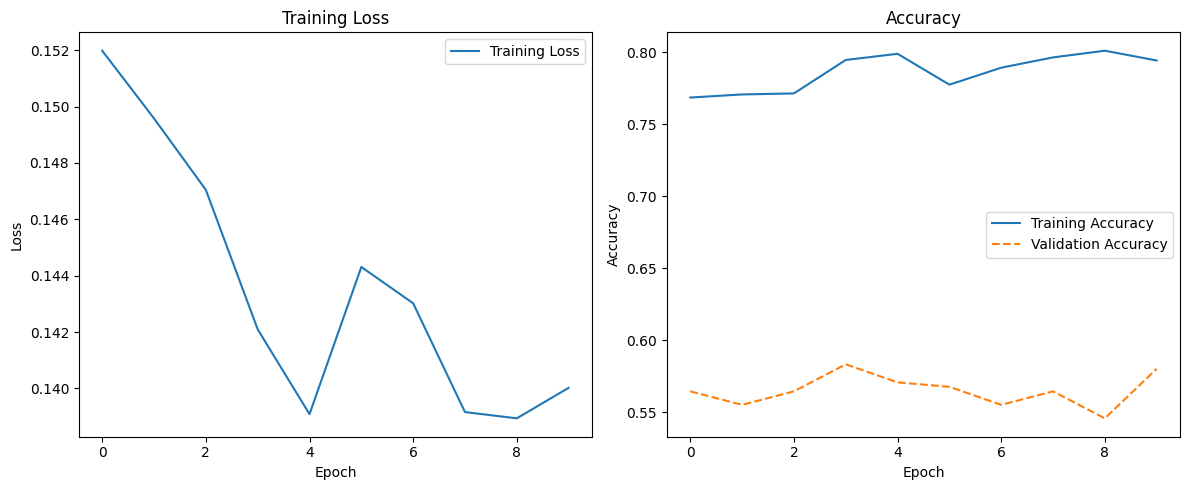

In [50]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def calculate_accuracy(logits, labels, threshold=0.5):
    preds = torch.sigmoid(logits).cpu().detach().numpy()
    preds = np.where(preds > threshold, 1, 0)
    labels = labels.cpu().detach().numpy()
    return accuracy_score(labels, preds)

best_accuracy = 0.0
best_epoch = 0
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    model.train()
    total_loss = 0
    train_accuracy = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs.logits, labels)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = train_accuracy / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            val_accuracy += calculate_accuracy(outputs.logits, labels)

    avg_val_accuracy = val_accuracy / len(val_loader)
    val_accuracies.append(avg_val_accuracy)

    print(f'Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_accuracy:.4f}')
    print(f'Validation Accuracy: {avg_val_accuracy:.4f}')

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), '/content/drive/MyDrive/AI/Crawl_Data/best_model_weights.pth')
        print(f'Best model saved with accuracy: {best_accuracy:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#**APPLYING TO SAMSUNG COMMENTS**


In [64]:
ss_df = pd.read_csv('/content/drive/MyDrive/AI/Crawl_Data/data/samsung_cmtdata.csv')
ss_df

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,Hình ảnh nét,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chất lượng tốt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sử dụng tốt ạ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ok,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mới lắp đặt ngày 07.03.2024. Mẫu mã đẹp sang t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
860,Ngon lành,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861,OK tivi xem rất tốt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,Tốt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
863,Rất tốt,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
prediction_dataset = CommentDataset(ss_df['Comment'].to_numpy(), None, tokenizer, MAX_LEN)
prediction_loader = DataLoader(prediction_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [67]:
model.eval()
all_predictions = []
with torch.no_grad():
    for batch in prediction_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs.logits).cpu().numpy() > 0.5
        all_predictions.extend(preds)

print("Shape of predictions:", np.array(all_predictions).shape)

Shape of predictions: (865, 21)


In [68]:
predictions_array = np.array(all_predictions)

if predictions_array.shape[0] == len(ss_df) * 7:
    predictions_df = pd.DataFrame(predictions_array.reshape(-1, 7), columns=label_cols)
    final_df = pd.concat([ss_df.reset_index(drop=True), predictions_df], axis=1)
    final_df.to_csv('/content/drive/MyDrive/AI/Crawl_Data/data/samsung_cmtdata_predicted.csv', index=False)
else:
    print("Mismatch in number of predictions and expected format")

Mismatch in number of predictions and expected format


In [69]:
predictions_array = np.array(all_predictions).reshape(-1, 7, 3)
predicted_indices = np.argmax(predictions_array, axis=2)
predictions_df = pd.DataFrame(predicted_indices, columns=label_cols)
final_df = pd.concat([ss_df.reset_index(drop=True), predictions_df], axis=1)

In [71]:
final_df = final_df.dropna(axis=1, how='any')

In [72]:
final_df

,Comment,giaodien,manhinh,amthanh,tinhnang,dichvu,giaca,tongthe
0,Hình ảnh nét,2,1,2,2,2,2,2
1,chất lượng tốt,2,2,2,2,2,2,1
2,Sử dụng tốt ạ,2,2,2,2,2,2,1
3,Ok,2,2,2,2,2,2,1
4,Mới lắp đặt ngày 07.03.2024. Mẫu mã đẹp sang t...,1,1,2,2,1,2,2
...,...,...,...,...,...,...,...,...
860,Ngon lành,2,2,2,2,2,2,1
861,OK tivi xem rất tốt,2,1,2,2,2,2,2
862,Tốt,2,2,2,2,2,2,1
863,Rất tốt,2,2,2,2,2,2,1


In [73]:
final_df.to_csv('/content/drive/MyDrive/AI/Crawl_Data/data/samsung_cmtdata_predicted.csv', index=False)

**Nhận xét**:

Khi check lại các file csv cuối cùng, em thấy việc dự đoán các trường hợp quen thuộc khá đúng (ví dụ như nhận xét thẳng vào hình ảnh, âm thanh, dịch vụ, ...) còn lại gặp những bình luận hầu như nhận về các đánh giá aspects là 0,...,0. Có thể do các comment này lạ (không được học trong bộ train cũng như không thể xuất hiện trong pretrained_weight của bert-base-multilingual-cased). Vì vậy mới xuất hiện hiện tượng giảm sâu về accuracy (acc của val không thể cao hơn 60%).

Điều này có thể khắc phục khi data đa dạng hơn nữa (hiện em đào data + áp dụng các augmentation chỉ có khoảng 3000 data và chất lượng data cũng thấp).



#**SINGLE INFERENCE**

In [6]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=21,
    problem_type="multi_label_classification"
)

model.load_state_dict(torch.load('/content/drive/MyDrive/AI/Crawl_Data/best_model_weights.pth'))
model.to(device)
model.eval()

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def predict_comment(comment, model, tokenizer, max_len=128):
    encoding = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()

    preds = np.argmax(preds.reshape(-1, 3), axis=1)

    label_cols = ['giaodien', 'manhinh', 'amthanh', 'tinhnang', 'dichvu', 'giaca', 'tongthe']
    results = {label_cols[i]: preds[i] for i in range(len(label_cols))}

    return results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [14]:
# Em test trong trường hợp kết hợp cả dùng thêm tiếng anh, và không dấu, không ngăn cách theo quy chuẩn câu, lộn xộn các khía cạnh
# Tuy nhiên em test thêm về lộn xộn các khía cạnh nó cũng không hiệu quả: Nguyên nhân có thể đến từ việc imbalance data tại các khía cạnh khác nên ghép chéo lại cũng chưa đủ tốt.
comment = "âm thanh nhỏ, Hình ảnh nét hỗ trợ giọng nói good. nhan vien nhiet tinh. ok"
result = predict_comment(comment, model, tokenizer)
print(result)

{'giaodien': 2, 'manhinh': 1, 'amthanh': 0, 'tinhnang': 1, 'dichvu': 1, 'giaca': 2, 'tongthe': 1}
